In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import data.Datasets
import models.Feedforward
import models.Attention
import utils.train

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [65]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 1

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)

In [66]:
# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')

model

ToyModel(
  (linear1): Linear(in_features=8, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (linear_output): Linear(in_features=8, out_features=1, bias=True)
  (layernorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)

In [67]:
importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

Epoch 000	 Train Loss: 0.90014	 Val Loss: 0.89047 	 Avg Error: 11.185	LR: 0.0001	Time: 9.7e+01
Epoch 001	 Train Loss: 0.23333	 Val Loss: 0.20108 	 Avg Error: 5.3151	LR: 0.0001	Time: 1.1e+02
Epoch 002	 Train Loss: 0.15081	 Val Loss: 0.21175 	 Avg Error: 5.4544	LR: 0.0001	Time: 1.1e+02
Epoch 003	 Train Loss: 0.12537	 Val Loss: 0.21181 	 Avg Error: 5.4551	LR: 0.0001	Time: 1.2e+02
Epoch 004	 Train Loss: 0.12382	 Val Loss: 0.19568 	 Avg Error: 5.2433	LR: 0.0001	Time: 1.2e+02
Epoch 005	 Train Loss: 0.1198	 Val Loss: 0.20619 	 Avg Error: 5.3822	LR: 0.0001	Time: 8e+01
Epoch 006	 Train Loss: 0.11259	 Val Loss: 0.20856 	 Avg Error: 5.413	LR: 0.0001	Time: 9.6e+01
Epoch 007	 Train Loss: 0.099813	 Val Loss: 0.15535 	 Avg Error: 4.6718	LR: 0.0001	Time: 1.1e+02
Epoch 008	 Train Loss: 0.096976	 Val Loss: 0.1852 	 Avg Error: 5.101	LR: 0.0001	Time: 1.2e+02
Epoch 009	 Train Loss: 0.094279	 Val Loss: 0.17226 	 Avg Error: 4.9194	LR: 0.0001	Time: 1.2e+02
Epoch 010	 Train Loss: 0.09266	 Val Loss: 0.16358 	 A

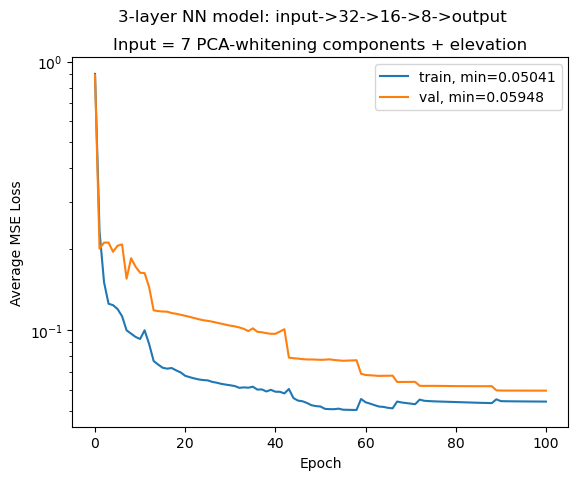

In [68]:
fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 7 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 0.98556	 Val Loss: 0.97413 	 Avg Error: 11.699	LR: 0.0001	Time: 6.1e+01
Epoch 001	 Train Loss: 0.24379	 Val Loss: 0.23289 	 Avg Error: 5.7202	LR: 0.0001	Time: 6.9e+01
Epoch 002	 Train Loss: 0.15612	 Val Loss: 0.21524 	 Avg Error: 5.4991	LR: 0.0001	Time: 6.8e+01
Epoch 003	 Train Loss: 0.13571	 Val Loss: 0.2166 	 Avg Error: 5.5164	LR: 0.0001	Time: 6.6e+01
Epoch 004	 Train Loss: 0.12853	 Val Loss: 0.22488 	 Avg Error: 5.6209	LR: 0.0001	Time: 6.7e+01
Epoch 005	 Train Loss: 0.11482	 Val Loss: 0.32466 	 Avg Error: 6.7537	LR: 0.0001	Time: 6.9e+01
Epoch 006	 Train Loss: 0.11995	 Val Loss: 0.25051 	 Avg Error: 5.9326	LR: 5e-05	Time: 6.7e+01
Epoch 007	 Train Loss: 0.10115	 Val Loss: 0.20881 	 Avg Error: 5.4163	LR: 5e-05	Time: 6.5e+01
Epoch 008	 Train Loss: 0.086468	 Val Loss: 0.14721 	 Avg Error: 4.5478	LR: 5e-05	Time: 6.9e+01
Epoch 009	 Train Loss: 0.084281	 Val Loss: 0.14143 	 Avg Error: 4.4575	LR: 5e-05	Time: 7e+01
Epoch 010	 Train Loss: 0.079457	 Val Loss: 0.13911 	 Av

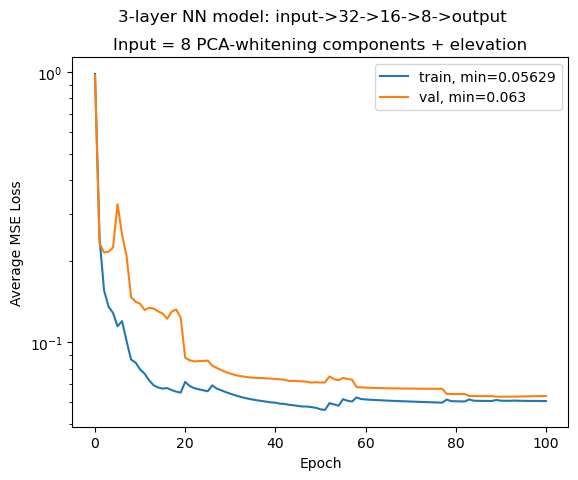

In [69]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 0

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 8 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.0911	 Val Loss: 1.0925 	 Avg Error: 12.389	LR: 0.0001	Time: 6.3e+01
Epoch 001	 Train Loss: 0.52912	 Val Loss: 0.40138 	 Avg Error: 7.5094	LR: 0.0001	Time: 7e+01
Epoch 002	 Train Loss: 0.26059	 Val Loss: 0.26201 	 Avg Error: 6.0672	LR: 0.0001	Time: 7.2e+01
Epoch 003	 Train Loss: 0.14004	 Val Loss: 0.20888 	 Avg Error: 5.4172	LR: 0.0001	Time: 7.1e+01
Epoch 004	 Train Loss: 0.12394	 Val Loss: 0.21748 	 Avg Error: 5.5276	LR: 0.0001	Time: 7.5e+01
Epoch 005	 Train Loss: 0.118	 Val Loss: 0.20433 	 Avg Error: 5.3579	LR: 0.0001	Time: 6.6e+01
Epoch 006	 Train Loss: 0.11027	 Val Loss: 0.19076 	 Avg Error: 5.177	LR: 0.0001	Time: 7e+01
Epoch 007	 Train Loss: 0.10267	 Val Loss: 0.19355 	 Avg Error: 5.2146	LR: 0.0001	Time: 7e+01
Epoch 008	 Train Loss: 0.091038	 Val Loss: 0.16021 	 Avg Error: 4.7444	LR: 0.0001	Time: 6.4e+01
Epoch 009	 Train Loss: 0.088511	 Val Loss: 0.15431 	 Avg Error: 4.6562	LR: 0.0001	Time: 6.5e+01
Epoch 010	 Train Loss: 0.085173	 Val Loss: 0.14661 	 Avg Er

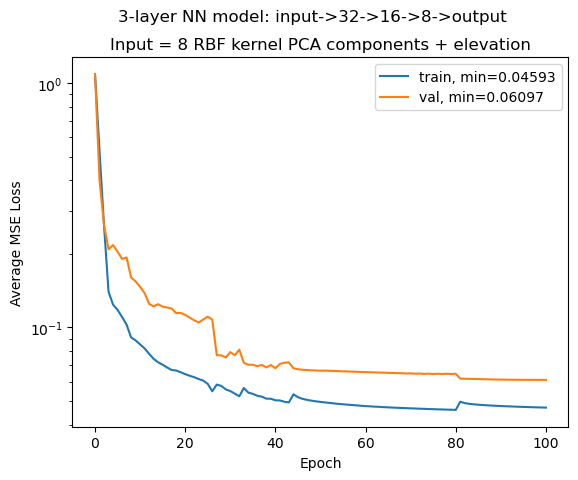

In [5]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 0

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\RBF\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\RBF\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 8 RBF kernel PCA components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 2.3235	 Val Loss: 2.3551 	 Avg Error: 18.19	LR: 0.0001	Time: 6.2e+01
Epoch 001	 Train Loss: 0.28343	 Val Loss: 0.23167 	 Avg Error: 5.7051	LR: 0.0001	Time: 6.6e+01
Epoch 002	 Train Loss: 0.16585	 Val Loss: 0.18275 	 Avg Error: 5.0671	LR: 0.0001	Time: 6.6e+01
Epoch 003	 Train Loss: 0.1451	 Val Loss: 0.20171 	 Avg Error: 5.3234	LR: 0.0001	Time: 7.3e+01
Epoch 004	 Train Loss: 0.13417	 Val Loss: 0.19487 	 Avg Error: 5.2324	LR: 0.0001	Time: 6.6e+01
Epoch 005	 Train Loss: 0.11497	 Val Loss: 0.20391 	 Avg Error: 5.3523	LR: 0.0001	Time: 6.5e+01
Epoch 006	 Train Loss: 0.1129	 Val Loss: 0.18779 	 Avg Error: 5.1365	LR: 5e-05	Time: 6.7e+01
Epoch 007	 Train Loss: 0.096152	 Val Loss: 0.16821 	 Avg Error: 4.8613	LR: 5e-05	Time: 7e+01
Epoch 008	 Train Loss: 0.084345	 Val Loss: 0.12402 	 Avg Error: 4.1741	LR: 5e-05	Time: 6.5e+01
Epoch 009	 Train Loss: 0.077847	 Val Loss: 0.12451 	 Avg Error: 4.1825	LR: 5e-05	Time: 6.5e+01
Epoch 010	 Train Loss: 0.074699	 Val Loss: 0.12581 	 Avg E

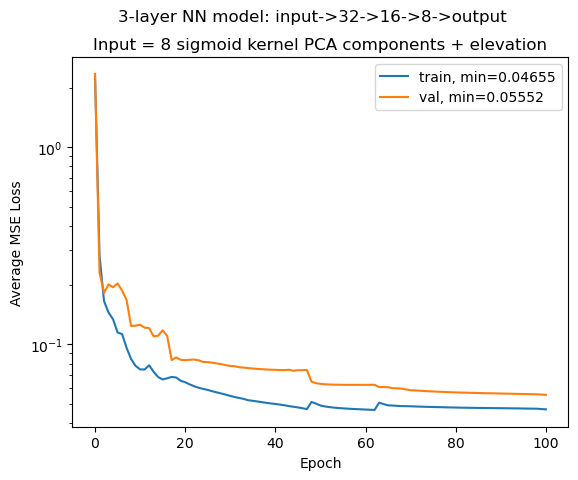

In [70]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 0

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\Sigmoid\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\Sigmoid\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 8 sigmoid kernel PCA components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.0073	 Val Loss: 0.97018 	 Avg Error: 11.675	LR: 0.0001	Time: 6e+01
Epoch 001	 Train Loss: 0.25305	 Val Loss: 0.21102 	 Avg Error: 5.4449	LR: 0.0001	Time: 7.6e+01
Epoch 002	 Train Loss: 0.14325	 Val Loss: 0.20091 	 Avg Error: 5.3129	LR: 0.0001	Time: 6.6e+01
Epoch 003	 Train Loss: 0.11432	 Val Loss: 0.23177 	 Avg Error: 5.7064	LR: 0.0001	Time: 6.5e+01
Epoch 004	 Train Loss: 0.10933	 Val Loss: 0.22308 	 Avg Error: 5.5983	LR: 0.0001	Time: 6.8e+01
Epoch 005	 Train Loss: 0.10246	 Val Loss: 0.39527 	 Avg Error: 7.4521	LR: 0.0001	Time: 7.1e+01
Epoch 006	 Train Loss: 0.10576	 Val Loss: 0.1941 	 Avg Error: 5.222	LR: 5e-05	Time: 6.6e+01
Epoch 007	 Train Loss: 0.1055	 Val Loss: 0.18804 	 Avg Error: 5.1399	LR: 5e-05	Time: 6.5e+01
Epoch 008	 Train Loss: 0.10135	 Val Loss: 0.18197 	 Avg Error: 5.0563	LR: 5e-05	Time: 7.5e+01
Epoch 009	 Train Loss: 0.09777	 Val Loss: 0.1767 	 Avg Error: 4.9825	LR: 5e-05	Time: 6.8e+01
Epoch 010	 Train Loss: 0.093845	 Val Loss: 0.16966 	 Avg Erro

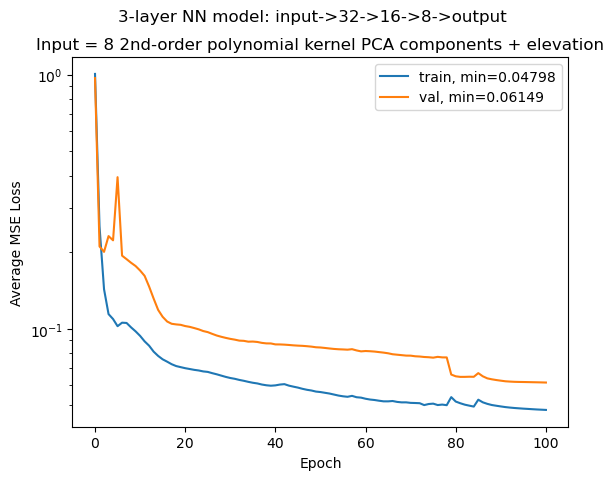

In [71]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 0

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\Poly2\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\Poly2\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 8 2nd-order polynomial kernel PCA components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.5964	 Val Loss: 1.5992 	 Avg Error: 14.989	LR: 0.0001	Time: 6.1e+01
Epoch 001	 Train Loss: 0.45886	 Val Loss: 0.28616 	 Avg Error: 6.3406	LR: 0.0001	Time: 6.5e+01
Epoch 002	 Train Loss: 0.18519	 Val Loss: 0.20095 	 Avg Error: 5.3134	LR: 0.0001	Time: 6.6e+01
Epoch 003	 Train Loss: 0.14873	 Val Loss: 0.19947 	 Avg Error: 5.2938	LR: 0.0001	Time: 7.3e+01
Epoch 004	 Train Loss: 0.11455	 Val Loss: 0.25065 	 Avg Error: 5.9342	LR: 0.0001	Time: 6.7e+01
Epoch 005	 Train Loss: 0.11723	 Val Loss: 0.2151 	 Avg Error: 5.4972	LR: 0.0001	Time: 6.6e+01
Epoch 006	 Train Loss: 0.10946	 Val Loss: 0.22125 	 Avg Error: 5.5754	LR: 0.0001	Time: 6.8e+01
Epoch 007	 Train Loss: 0.11481	 Val Loss: 0.19544 	 Avg Error: 5.2401	LR: 5e-05	Time: 7e+01
Epoch 008	 Train Loss: 0.11129	 Val Loss: 0.16914 	 Avg Error: 4.8748	LR: 5e-05	Time: 6.5e+01
Epoch 009	 Train Loss: 0.10519	 Val Loss: 0.20204 	 Avg Error: 5.3278	LR: 5e-05	Time: 6.7e+01
Epoch 010	 Train Loss: 0.097981	 Val Loss: 0.19317 	 Avg E

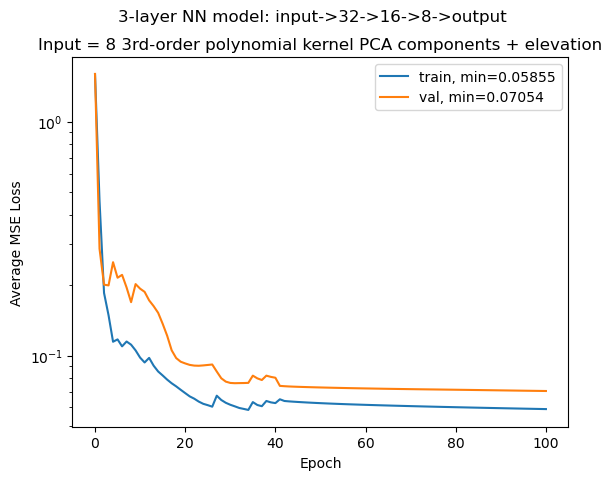

In [72]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 0

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\Poly3\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'KPCA\\Poly3\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 8 3rd-order polynomial kernel PCA components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 0.85532	 Val Loss: 0.84564 	 Avg Error: 10.9	LR: 0.0001	Time: 6.6e+01
Epoch 001	 Train Loss: 0.15157	 Val Loss: 0.20554 	 Avg Error: 5.3737	LR: 0.0001	Time: 6.8e+01
Epoch 002	 Train Loss: 0.10282	 Val Loss: 0.19752 	 Avg Error: 5.2678	LR: 0.0001	Time: 7.4e+01
Epoch 003	 Train Loss: 0.064521	 Val Loss: 0.15344 	 Avg Error: 4.643	LR: 0.0001	Time: 7.1e+01
Epoch 004	 Train Loss: 0.050955	 Val Loss: 0.17146 	 Avg Error: 4.908	LR: 0.0001	Time: 6.8e+01
Epoch 005	 Train Loss: 0.04276	 Val Loss: 0.34685 	 Avg Error: 6.9807	LR: 0.0001	Time: 7.5e+01
Epoch 006	 Train Loss: 0.043639	 Val Loss: 0.1649 	 Avg Error: 4.8133	LR: 0.0001	Time: 7.2e+01
Epoch 007	 Train Loss: 0.04004	 Val Loss: 0.12072 	 Avg Error: 4.1182	LR: 5e-05	Time: 7e+01
Epoch 008	 Train Loss: 0.034254	 Val Loss: 0.11175 	 Avg Error: 3.9624	LR: 5e-05	Time: 6.9e+01
Epoch 009	 Train Loss: 0.03252	 Val Loss: 0.11366 	 Avg Error: 3.996	LR: 5e-05	Time: 7.5e+01
Epoch 010	 Train Loss: 0.030591	 Val Loss: 0.11282 	 Avg 

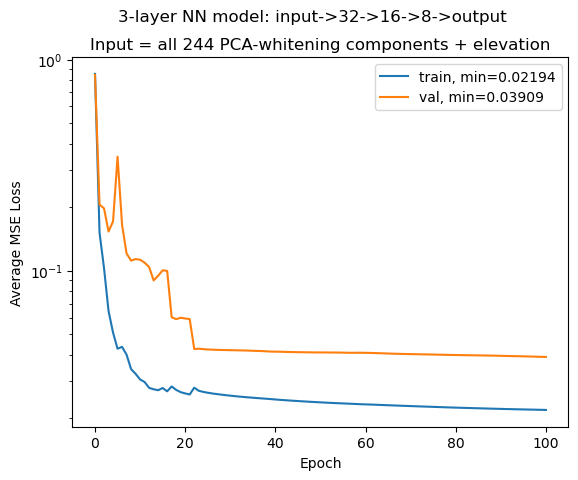

In [6]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 0

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = all 244 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 2.9773	 Val Loss: 3.026 	 Avg Error: 20.619	LR: 0.0001	Time: 5.9e+01
Epoch 001	 Train Loss: 0.33121	 Val Loss: 0.26341 	 Avg Error: 6.0833	LR: 0.0001	Time: 6.4e+01
Epoch 002	 Train Loss: 0.14625	 Val Loss: 0.21978 	 Avg Error: 5.5567	LR: 0.0001	Time: 6.7e+01
Epoch 003	 Train Loss: 0.15417	 Val Loss: 0.21538 	 Avg Error: 5.5009	LR: 0.0001	Time: 6.8e+01
Epoch 004	 Train Loss: 0.13358	 Val Loss: 0.2032 	 Avg Error: 5.3431	LR: 0.0001	Time: 6.4e+01
Epoch 005	 Train Loss: 0.12231	 Val Loss: 0.2075 	 Avg Error: 5.3993	LR: 0.0001	Time: 6.9e+01
Epoch 006	 Train Loss: 0.096827	 Val Loss: 0.17402 	 Avg Error: 4.9446	LR: 0.0001	Time: 7e+01
Epoch 007	 Train Loss: 0.091286	 Val Loss: 0.15284 	 Avg Error: 4.634	LR: 0.0001	Time: 6.8e+01
Epoch 008	 Train Loss: 0.091218	 Val Loss: 0.15636 	 Avg Error: 4.687	LR: 0.0001	Time: 6.4e+01
Epoch 009	 Train Loss: 0.085668	 Val Loss: 0.1467 	 Avg Error: 4.5398	LR: 0.0001	Time: 6.9e+01
Epoch 010	 Train Loss: 0.080004	 Val Loss: 0.13575 	 Avg

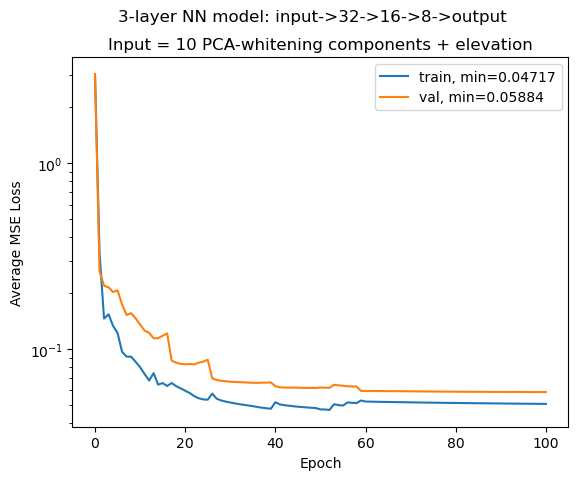

In [7]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 234

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 10 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 0.45121	 Val Loss: 0.43179 	 Avg Error: 7.7886	LR: 0.0001	Time: 5.9e+01
Epoch 001	 Train Loss: 0.25387	 Val Loss: 0.28373 	 Avg Error: 6.3136	LR: 0.0001	Time: 6.6e+01
Epoch 002	 Train Loss: 0.14254	 Val Loss: 0.19791 	 Avg Error: 5.2731	LR: 0.0001	Time: 6.8e+01
Epoch 003	 Train Loss: 0.11155	 Val Loss: 0.26269 	 Avg Error: 6.075	LR: 0.0001	Time: 6.9e+01
Epoch 004	 Train Loss: 0.1141	 Val Loss: 0.21882 	 Avg Error: 5.5446	LR: 0.0001	Time: 6.2e+01
Epoch 005	 Train Loss: 0.099518	 Val Loss: 0.30094 	 Avg Error: 6.5023	LR: 0.0001	Time: 6.8e+01
Epoch 006	 Train Loss: 0.095216	 Val Loss: 0.16052 	 Avg Error: 4.7489	LR: 5e-05	Time: 7e+01
Epoch 007	 Train Loss: 0.092866	 Val Loss: 0.14758 	 Avg Error: 4.5535	LR: 5e-05	Time: 6.3e+01
Epoch 008	 Train Loss: 0.090693	 Val Loss: 0.15499 	 Avg Error: 4.6663	LR: 5e-05	Time: 6.3e+01
Epoch 009	 Train Loss: 0.087056	 Val Loss: 0.13716 	 Avg Error: 4.3897	LR: 5e-05	Time: 7e+01
Epoch 010	 Train Loss: 0.08471	 Val Loss: 0.1381 	 Avg 

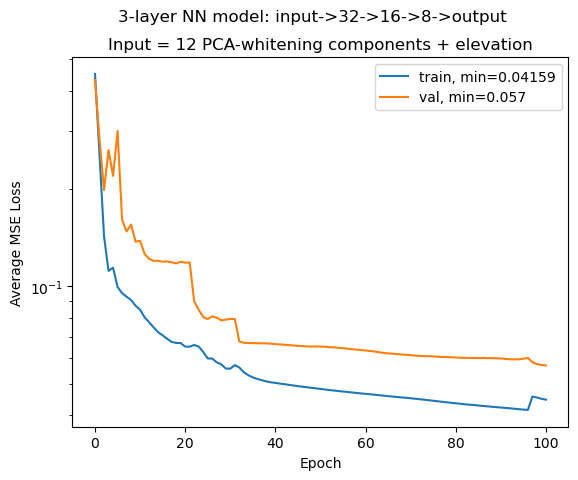

In [8]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 232

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 12 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.5877	 Val Loss: 1.5941 	 Avg Error: 14.965	LR: 0.0001	Time: 5.7e+01
Epoch 001	 Train Loss: 0.20727	 Val Loss: 0.26976 	 Avg Error: 6.1563	LR: 0.0001	Time: 6.8e+01
Epoch 002	 Train Loss: 0.13073	 Val Loss: 0.22276 	 Avg Error: 5.5943	LR: 0.0001	Time: 6.7e+01
Epoch 003	 Train Loss: 0.11134	 Val Loss: 0.20207 	 Avg Error: 5.3282	LR: 0.0001	Time: 6.6e+01
Epoch 004	 Train Loss: 0.10189	 Val Loss: 0.18471 	 Avg Error: 5.0941	LR: 0.0001	Time: 6.2e+01
Epoch 005	 Train Loss: 0.10353	 Val Loss: 0.20534 	 Avg Error: 5.3711	LR: 0.0001	Time: 7e+01
Epoch 006	 Train Loss: 0.087818	 Val Loss: 0.15502 	 Avg Error: 4.6669	LR: 0.0001	Time: 6.4e+01
Epoch 007	 Train Loss: 0.082636	 Val Loss: 0.1447 	 Avg Error: 4.5089	LR: 0.0001	Time: 6.2e+01
Epoch 008	 Train Loss: 0.074474	 Val Loss: 0.12496 	 Avg Error: 4.1899	LR: 0.0001	Time: 6.2e+01
Epoch 009	 Train Loss: 0.074752	 Val Loss: 0.13128 	 Avg Error: 4.2946	LR: 0.0001	Time: 7e+01
Epoch 010	 Train Loss: 0.067767	 Val Loss: 0.13154 	 

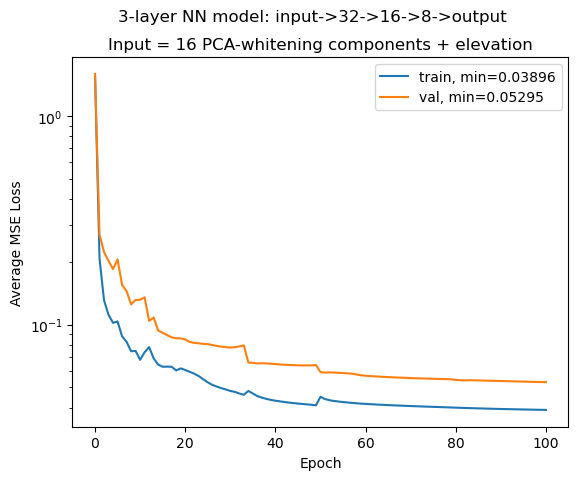

In [9]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 228

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 16 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 2.5252	 Val Loss: 2.5378 	 Avg Error: 18.883	LR: 0.0001	Time: 6.3e+01
Epoch 001	 Train Loss: 0.2128	 Val Loss: 0.30335 	 Avg Error: 6.5283	LR: 0.0001	Time: 6.5e+01
Epoch 002	 Train Loss: 0.13378	 Val Loss: 0.20055 	 Avg Error: 5.3081	LR: 0.0001	Time: 7.1e+01
Epoch 003	 Train Loss: 0.11357	 Val Loss: 0.21828 	 Avg Error: 5.5378	LR: 0.0001	Time: 6.7e+01
Epoch 004	 Train Loss: 0.10245	 Val Loss: 0.17946 	 Avg Error: 5.0212	LR: 0.0001	Time: 6.7e+01
Epoch 005	 Train Loss: 0.087744	 Val Loss: 0.19351 	 Avg Error: 5.2141	LR: 0.0001	Time: 6.9e+01
Epoch 006	 Train Loss: 0.072584	 Val Loss: 0.13715 	 Avg Error: 4.3896	LR: 0.0001	Time: 7e+01
Epoch 007	 Train Loss: 0.060905	 Val Loss: 0.15472 	 Avg Error: 4.6623	LR: 0.0001	Time: 6.8e+01
Epoch 008	 Train Loss: 0.055562	 Val Loss: 0.18488 	 Avg Error: 5.0966	LR: 0.0001	Time: 6.8e+01
Epoch 009	 Train Loss: 0.052952	 Val Loss: 0.12573 	 Avg Error: 4.2029	LR: 0.0001	Time: 7.1e+01
Epoch 010	 Train Loss: 0.048405	 Val Loss: 0.2539 

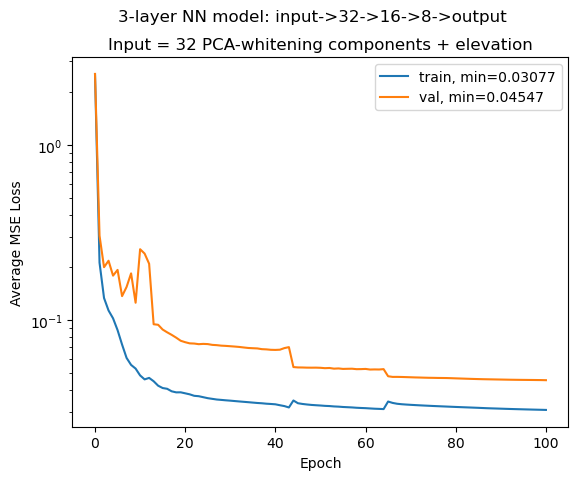

In [10]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 212

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 32 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.0738	 Val Loss: 1.0652 	 Avg Error: 12.234	LR: 0.0001	Time: 6.4e+01
Epoch 001	 Train Loss: 0.16502	 Val Loss: 0.2176 	 Avg Error: 5.5292	LR: 0.0001	Time: 6.5e+01
Epoch 002	 Train Loss: 0.11772	 Val Loss: 0.18726 	 Avg Error: 5.1292	LR: 0.0001	Time: 6.4e+01
Epoch 003	 Train Loss: 0.10658	 Val Loss: 0.1829 	 Avg Error: 5.0691	LR: 0.0001	Time: 6.6e+01
Epoch 004	 Train Loss: 0.10499	 Val Loss: 0.18821 	 Avg Error: 5.1422	LR: 0.0001	Time: 6.4e+01
Epoch 005	 Train Loss: 0.078813	 Val Loss: 0.13618 	 Avg Error: 4.3741	LR: 0.0001	Time: 6.4e+01
Epoch 006	 Train Loss: 0.062655	 Val Loss: 0.12488 	 Avg Error: 4.1887	LR: 0.0001	Time: 7e+01
Epoch 007	 Train Loss: 0.050638	 Val Loss: 0.29458 	 Avg Error: 6.4333	LR: 0.0001	Time: 6.8e+01
Epoch 008	 Train Loss: 0.046326	 Val Loss: 0.27717 	 Avg Error: 6.2402	LR: 0.0001	Time: 6.7e+01
Epoch 009	 Train Loss: 0.040444	 Val Loss: 0.14186 	 Avg Error: 4.4643	LR: 0.0001	Time: 6.4e+01
Epoch 010	 Train Loss: 0.045565	 Val Loss: 0.091941

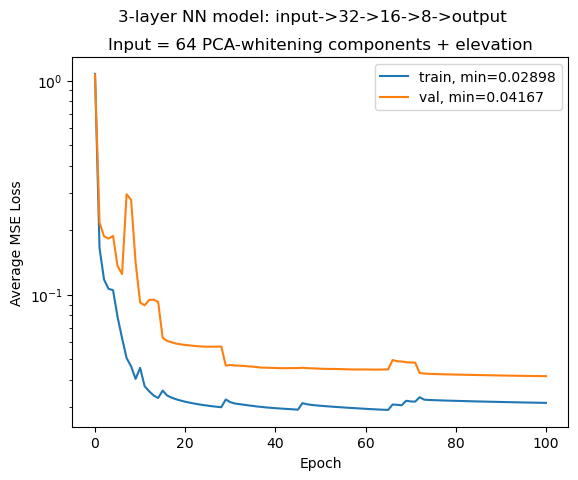

In [11]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 180

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 64 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.0771	 Val Loss: 1.0733 	 Avg Error: 12.28	LR: 0.0001	Time: 5.9e+01
Epoch 001	 Train Loss: 0.23347	 Val Loss: 0.21688 	 Avg Error: 5.52	LR: 0.0001	Time: 7e+01
Epoch 002	 Train Loss: 0.10858	 Val Loss: 0.21538 	 Avg Error: 5.5009	LR: 0.0001	Time: 7e+01
Epoch 003	 Train Loss: 0.087633	 Val Loss: 0.1884 	 Avg Error: 5.1448	LR: 0.0001	Time: 6.6e+01
Epoch 004	 Train Loss: 0.059216	 Val Loss: 0.15919 	 Avg Error: 4.7292	LR: 0.0001	Time: 6.8e+01
Epoch 005	 Train Loss: 0.050374	 Val Loss: 0.12536 	 Avg Error: 4.1967	LR: 0.0001	Time: 7.1e+01
Epoch 006	 Train Loss: 0.044	 Val Loss: 0.18586 	 Avg Error: 5.11	LR: 0.0001	Time: 6.9e+01
Epoch 007	 Train Loss: 0.035857	 Val Loss: 0.21141 	 Avg Error: 5.45	LR: 0.0001	Time: 6.7e+01
Epoch 008	 Train Loss: 0.036143	 Val Loss: 0.18465 	 Avg Error: 5.0934	LR: 0.0001	Time: 7e+01
Epoch 009	 Train Loss: 0.034581	 Val Loss: 0.11057 	 Avg Error: 3.9414	LR: 5e-05	Time: 7.1e+01
Epoch 010	 Train Loss: 0.034649	 Val Loss: 0.098076 	 Avg Error

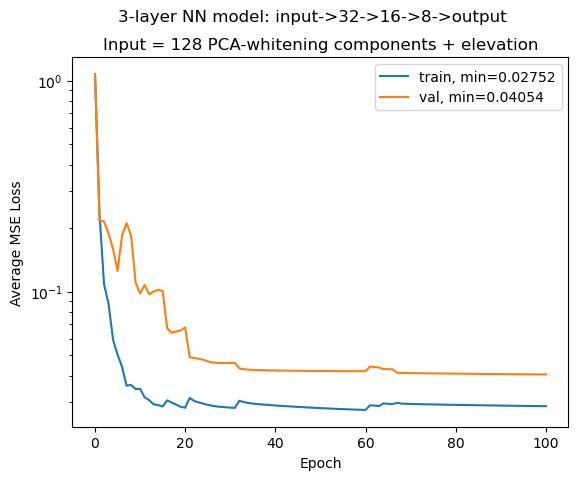

In [12]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 116

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 128 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)